In [1]:
import os
from typing import Optional

# Important! Uncomment this line to set your own API key
# os.environ["OPEN_AI_KEY"] = "sk-..."

from utils import *

# 1. Python in 10 minutes

This interface allows you to run Python code interactively and view the results immediately, along with any visualizations or text explanations. Each block of code or text you see is contained in what we call a "cell."

## Basic Operations

- **Running a Cell**: You can run the code or render the markdown in a cell by selecting it and pressing `Shift + Enter`, or by clicking the "Run" button in the toolbar.
- **Adding New Cells**: Add a new cell by clicking the "+" button in the toolbar.
- **Cell Types**: Cells can be code cells or markdown cells. Switch the type using the dropdown in the toolbar.


In [2]:
# Simple Python Example

# Printing a message
print("Hello, World!")

# Basic arithmetic
result = 7 * 6
print("7 multiplied by 6 is", result)

Hello, World!
7 multiplied by 6 is 42


In [3]:
# Using Variables

# Store a value in a variable
a = 10

# Use the variable in a calculation
b = a * 2

# Print the result
print("The result of a multiplied by 2 is", b)

The result of a multiplied by 2 is 20


In [4]:
# Basic Data Structures

# List: an ordered collection of items
fruits = ["apple", "banana", "cherry"]
print("Fruits List:", fruits)

# Dictionary: key-value pairs
prices = {"apple": 0.40, "banana": 0.50, "cherry": 0.30}
print("Fruit Prices:", prices)

Fruits List: ['apple', 'banana', 'cherry']
Fruit Prices: {'apple': 0.4, 'banana': 0.5, 'cherry': 0.3}


In [5]:
# Looping through a list
for fruit in fruits:
    print(fruit, "costs", prices[fruit], "each")

# Conditional: if statement
if "banana" in fruits:
    print("Yes, we have bananas!")

apple costs 0.4 each
banana costs 0.5 each
cherry costs 0.3 each
Yes, we have bananas!


### Introduction to Functions

Functions are a way to organize your code into blocks that can be called multiple times throughout your program. They allow you to write cleaner, more modular code and make your scripts easier to maintain and debug. Functions in Python are defined using the `def` keyword.


In [6]:
# Defining a Simple Function


def greet(name):
    """This function greets the person whose name is passed as a parameter"""
    return f"Hello, {name}! Welcome to our notebook."


# Calling the function
greeting = greet("Alice")
print(greeting)

Hello, Alice! Welcome to our notebook.


In [7]:
# Function with Parameters and Return Value


def calculate_area(length, width):
    """This function returns the area of a rectangle given its length and width."""
    area = length * width
    return area


# Using the function
rect_area = calculate_area(10, 5)
print("The area of the rectangle is:", rect_area)

The area of the rectangle is: 50


### Creating Prompts 

In [8]:
# you can add a variable to a string by using format

name = "Lebron James"

template = """{name} is from Ohio"""

print("Without calling format:", template)
print("After calling format:", template.format(name=name))

Without calling format: {name} is from Ohio
After calling format: Lebron James is from Ohio


### Let's get started with the case study!


# High Level Architecture

The architecture of the system is as follows:

1. We chunk up the document into distinct “sections” and embed those sections
2. Then, we embed the user query and find the most similar part of the document.
3. We feed the original question along with context we found to the LLM and receive an answer


# 2. What exactly is an embedding?


In [9]:
from openai import OpenAI, NOT_GIVEN
import plotly.graph_objects as go

#########################
### UTILITY FUNCTIONS ###
#########################

# instantiating the OpenAI client
client = OpenAI(api_key=os.getenv("OPEN_AI_KEY"))
batch_size = 250
embedding_model = "text-embedding-3-small"


# wrapper function around openai to directly return embedding of text
def get_embedding(text: str | list[str], dimensions: int = NOT_GIVEN) -> list[float]:
    """Get the embedding of the input text."""
    if dimensions:
        assert dimensions <= 256, "The maximum number of dimensions is 256."

    response = client.embeddings.create(
        input=text, model=embedding_model, dimensions=dimensions
    )
    return response.data[0].embedding


def get_many_embeddings(texts: list[str]) -> list[list[float]]:
    """Get the embeddings of multiple texts."""
    batch_size = 250
    res = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        api_resp = client.embeddings.create(input=batch_texts, model=embedding_model)
        batch_res = [val.embedding for val in api_resp.data]
        res.extend(batch_res)

    return res


# simple utility function to add a vector to a 3D plot
def add_vector_to_graph(
    fig: go.Figure, vector: list[float], color: str = "red", name: Optional[str] = None
) -> go.Figure:
    # Ensure vector has exactly three components
    assert len(vector) == 3, "Vector must have exactly 3 components to visualize."

    # Origin point
    origin = [0, 0, 0]

    # Components of the vector
    x_component, y_component, z_component = vector

    # Adding the line part of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[origin[0], x_component],
            y=[origin[1], y_component],
            z=[origin[2], z_component],
            mode="lines",
            line=dict(color=color, width=5),
            name=name,
        )
    )

    # Adding the cone at the tip of the vector
    fig.add_trace(
        go.Cone(
            x=[x_component],
            y=[y_component],
            z=[z_component],
            u=[x_component],
            v=[y_component],
            w=[z_component],
            sizemode="scaled",
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, color], [1, color]],
            hoverinfo="none",
        )
    )
    return fig


def create_new_graph() -> go.Figure:
    """Create a 3D plotly figure with a simple layout."""
    fig = go.Figure()

    # make sure the plot isn't rotated
    fig.update_layout(
        scene=dict(
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=0.5),  # Adjust the camera position
                up=dict(x=0, y=0, z=1),  # Sets the z-axis as "up"
                center=dict(x=0, y=0, z=0),  # Focuses the camera on the origin
            ),
            aspectmode="cube",
        )
    )

    # Add a dot at the origin
    fig.add_trace(
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            mode="markers",
            marker=dict(size=6, color="black", symbol="circle"),
            name="Origin",
        )
    )

    return fig

#### Let's get started

For the purpose of the notebook we're going to use an OpenAI approach.

In [10]:
# let's try using the get_embedding function
result = get_embedding("lead contamination")
print(result)

[0.0016759572317823768, -0.02065727859735489, 0.039297010749578476, 0.03164839744567871, -0.027221838012337685, -0.00540522113442421, 0.012225736863911152, -0.013196869753301144, -0.053329505026340485, -0.00663231173530221, 0.05483514070510864, -0.014055080711841583, 0.006158037111163139, -0.015508015640079975, -0.009417732246220112, 0.008950985968112946, 0.032461438328027725, -0.030097596347332, -0.0720294639468193, 0.00593219231814146, 0.020943349227309227, 0.0407424196600914, 0.036074958741664886, 0.026709921658039093, -0.018459055572748184, -0.03231087699532509, 0.017465338110923767, -0.020973462611436844, -0.005792921409010887, 0.0004926241817884147, 0.017088929191231728, -0.03601473197340965, -0.01659207046031952, -0.022659771144390106, -0.0031241877004504204, -0.015733860433101654, 0.06498309969902039, -0.00671512121334672, -0.03730957582592964, -0.026453964412212372, -0.027613302692770958, 0.02678520418703556, 0.019979745149612427, 0.02171122282743454, 0.006692537106573582, 0.0

That's a lot of numbers! OpenAI embedding support built in dimensionality reduction - let's try using that and visualizing the result


In [11]:
graph = create_new_graph()

text = "lead contamination"

# Get the embedding of the text
vector = get_embedding(text, dimensions=3)
print(f"Resulting vector: {vector} with {len(vector)} dimensions")

# Add the vector to the plot
add_vector_to_graph(graph, vector, name=text)

# Show the plot
graph.show()

Resulting vector: [0.03772357106208801, -0.46496790647506714, 0.8845235109329224] with 3 dimensions


Let's try plotting a couple vectors at once to see if we can see any patterns

In [12]:
graph = create_new_graph()

text = "lead contamination"
lead_contamination_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, lead_contamination_vector, name=text, color="purple")

text = "asbestos"
asbestos_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, asbestos_vector, name=text, color="blue")

text = "judo"
judo_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, judo_vector, name=text, color="red")

# Show the plot
graph.show()

How we can quantify the similarity between two vectors? One common way is to use the cosine similarity. The cosine similarity between two vectors is the cosine of the angle between them. It ranges from -1 (opposite directions) to 1 (same direction), with 0 indicating orthogonality.

*Note:* You can try your own vectors by changing the text variable in the code above. You may see unintuitive results because we're only using 3 dimensions - increasing the dimensions will help (although we won't be able to visualize it).


In [13]:
import numpy as np


def cosine_similarity(a: list[float], b: list[float]) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# We can use the cosine similarity to compare the similarity between two vectors
similarity = cosine_similarity(lead_contamination_vector, judo_vector)
print(f"The similarity between 'lead contamination' and 'judo' is {similarity:.2f}")

similarity = cosine_similarity(lead_contamination_vector, asbestos_vector)
print(f"The similarity between 'lead contamination' and 'asbestos' is {similarity:.2f}")

The similarity between 'lead contamination' and 'judo' is -0.65
The similarity between 'lead contamination' and 'asbestos' is 0.96


# 3. Parsing Documents

Large language models are currently primarly optimized for working with text. As a result when dealing with documents like PDF's we need to first convert them into a text format before we can feed them into the model.

We maintain a popular open source library for doing this called [openparse](https://github.com/Filimoa/open-parse/). It is a simple and easy to use.


In [14]:
import openparse

#########################
### UTILITY FUNCTIONS ###
#########################


class VectorDatabase:
    """
    A simple in-memory database to store nodes along with their vectors and perform similarity search.
    """

    def __init__(self):
        self.nodes = []

    def add_node(self, node: openparse.Node) -> None:
        """Add a node along with its vector to the database."""
        assert node.embedding is not None, "Node must have an embedding."

        for existing_node in self.nodes:
            if existing_node.text == node.text:
                print(f"Node with id {node.node_id} already exists. Skipping")
                return

        self.nodes.append(node)

    def find_node(self, node_id: str):
        """Retrieve a node by its ID."""
        for node in self.nodes:
            if node.node_id == node_id:
                return node
        return None

    def find_similar_node(
        self, input_vector: list[float], top_k: int = 3
    ) -> list[openparse.Node]:
        """Find the top_k nodes with the highest cosine similarity to the input_vector."""
        assert self.nodes, "Database is empty. Please add nodes first."
        assert top_k <= len(self.nodes), (
            "top_k should be less than or equal to the number of nodes."
        )

        similarities = []
        for node in self.nodes:
            similarity = cosine_similarity(input_vector, node.embedding)
            similarities.append((node, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)

        return [node for node, _ in similarities[:top_k]]

    @property
    def num_nodes(self) -> int:
        """Return the number of nodes in the database."""
        return len(self.nodes)

    def delete_all_nodes(self) -> None:
        """Delete all nodes from the database."""
        self.nodes = []


db = VectorDatabase()

In [15]:
import openparse

doc_path = "./docs/portland-site-assessment-phase-1.pdf"
pdf = openparse.Pdf(doc_path)
parser = openparse.DocumentParser()
parsed_doc = parser.parse(doc_path)

Let's try looking at the first couple nodes.

In [16]:
for node in parsed_doc.nodes[10:11]:
    display(node)
    print("====================================")

RECOGNIZED ENVIRONMENTAL CONDITIONS <br><br>ASTM E1527-13 defines RECs as the presence or likely presence of any hazardous substances or 
petroleum products in, on, or at a property: (1) due to any release to the environment; (2) under 
conditions indicative of a release to the environment; or (3) under conditions that pose a material 
threat of a future release to the environment. <br><br>No uncontrolled RECs were identified for the Property. <br><br>CONTROLLED RECOGNIZED ENVIRONMENTAL CONDITIONS <br><br>ASTM E1527-13 defines controlled RECs (CRECs) as resulting from a past release of hazardous 
substances or petroleum products that has been addressed to the satisfaction of the applicable 
regulatory authority. <br><br>The CRECs identified through completion of this Phase I ESA are noted below and are discussed in 
further detail throughout this report. Figure ES-1 displays the area names used to describe different 
portions of the Property. <br><br>• Groundwater concentration in excess of the DEQ residential, urban residential, and 
occupational risk-based concentrations (RBCs) for lead, arsenic, polycyclic aromatic 
hydrocarbons (PAHs), diesel-range organics (DRO), and residual-range organics (RRO) 
have been observed on portions of the Property. In addition, benzo(a)pyrene (a PAH) 
was observed in groundwater in excess of the DEQ excavation worker RBC in two 
locations on the southeastern portion of the Property (one in Riverside and one in the 
Barker Area). <br><br>• PAHs in shallow soil above the DEQ residential, urban residential, and occupational <br><br>RBCs in the Lumber Mill Area. 

Now let's embed all the nodes and add to the database.

<img src="https://sergey-filimonov.nyc3.cdn.digitaloceanspaces.com/misc/misc-data-or-images-for-notebooks/parsing-v2.png" alt="Parsing Overview" style="width: 80%; height: auto; display: block; margin-left: auto; margin-right: auto;">

In [17]:
# let's embed all the nodes and add to the database
raw_node_texts = [node.text for node in parsed_doc.nodes]
embeddings = get_many_embeddings(raw_node_texts)

for node, embedding in zip(parsed_doc.nodes, embeddings):
    node.embedding = embedding
    db.add_node(node)

print("=== Database now has ", db.num_nodes, " nodes ===")

Node with id 02444695-34f5-4094-b712-5b6e9fb744a2 already exists. Skipping
=== Database now has  77  nodes ===


# 4. Querying

In [18]:
#########################
### UTILITY FUNCTIONS ###
#########################

from IPython.display import Markdown


def get_completion(prompt: str) -> Markdown:
    """
    OpenAI returns a complex object, this is a simple wrapper function to directly return the completion text.
    """
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    cost_per_million_tokens = 4.00
    cost_dollars = completion.usage.total_tokens / 1_000_000 * cost_per_million_tokens

    print(
        f"Completion used {completion.usage.total_tokens} tokens costing ${cost_dollars:.2f}"
    )

    return Markdown(completion.choices[0].message.content)


def display_similar_nodes(
    similar_nodes: list[openparse.Node], query_vector: list[float], pdf: openparse.Pdf
) -> None:
    page_nums = set()
    annotations = []
    for node in similar_nodes:
        sim = cosine_similarity(query_vector, node.embedding)
        page_nums.add(node.start_page)
        page_nums.add(node.end_page)
        annotations.append(round(sim, 3))

    pdf.display_with_bboxes(similar_nodes, page_nums=page_nums, annotations=annotations)

In [19]:
# let's try asking one of our original questions

question = "Is there lead contamination into the groundwater?"

# Get the embedding of the text
query_vector = get_embedding(question)

# find the most similar node
similar_nodes = db.find_similar_node(query_vector, top_k=5)

for node in similar_nodes:
    sim = cosine_similarity(query_vector, node.embedding)
    print(
        f"Found similar node on page {node.start_page} with a similarity of {sim:.2f}"
    )

Found similar node on page 24 with a similarity of 0.55
Found similar node on page 26 with a similarity of 0.54
Found similar node on page 31 with a similarity of 0.54
Found similar node on page 28 with a similarity of 0.54
Found similar node on page 28 with a similarity of 0.53


In [20]:
# create a single string of all the similar nodes
context = "\n\n".join([node.text for node in similar_nodes])

print(context)

Lead-impacted soil along a portion of the northwestern periphery of the Property was also observed 
in samples collected from test pits. Approximately 1,708 tons of impacted soil was excavated from 
this area and disposed of off site. The target cleanup levels used during this removal action were 400 
parts per million (ppm) for soil up to 3 feet bgs and 800 ppm for soil at depths greater than 3 feet. A 
description of the confirmation samples and sample results includes a thin layer of residual soil on 
bedrock in the deepest part of the excavation (approximately 5-10 feet bgs), with concentrations 
remaining above target cleanup levels. Additionally, residual lead levels above RBCs for both 
residential and construction/excavation workers are present in samples along the northern sidewall 
of the excavation within about 3 feet of the property boundary. Impacted soil near the property 
boundary could not be removed due to concerns about damaging the adjacent building to the north, 
or

### Ok let's try running a completion

To reiterate, we first query the document for the most relevant information using the vector search. Then we feed the question and the context into the LLM to get an answer.

<img src="https://sergey-filimonov.nyc3.cdn.digitaloceanspaces.com/misc/misc-data-or-images-for-notebooks/eca-docs-rag-overview-v2.png">

In [21]:
prompt_template = """
Using the document provided, answer the following question:

question: {question}

context: {context}
"""

prompt = prompt_template.format(question=question, context=context)

completion = get_completion(prompt)

print("Original Question:", question)
completion

Completion used 1403 tokens costing $0.01
Original Question: Is there lead contamination into the groundwater?


Yes, there is lead contamination in groundwater. The document indicates that lead concentrations in groundwater exceeded residential, urban residential, and occupational risk-based concentrations (RBCs) in three of four locations assessed in the Lathe Area. However, lead was not detected above RBCs in the Riverside samples.

### We can display citations showing users exactly where we got our answer

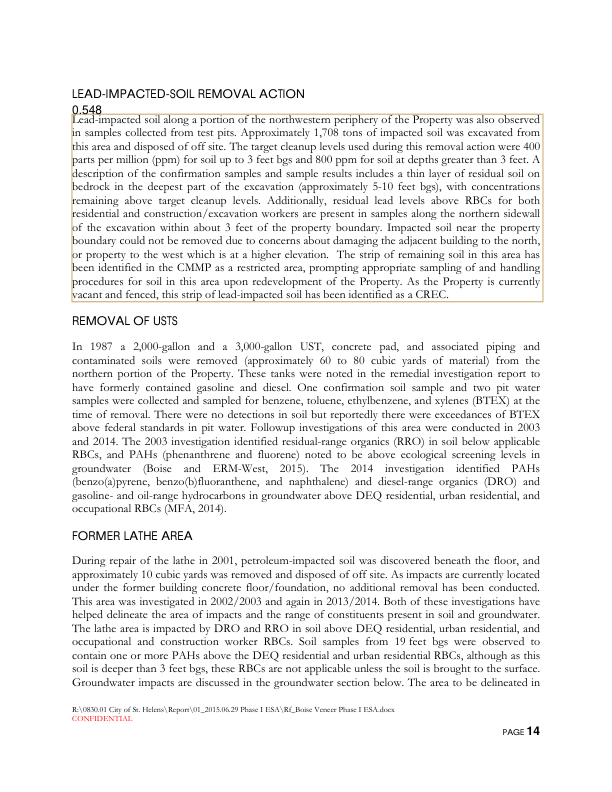

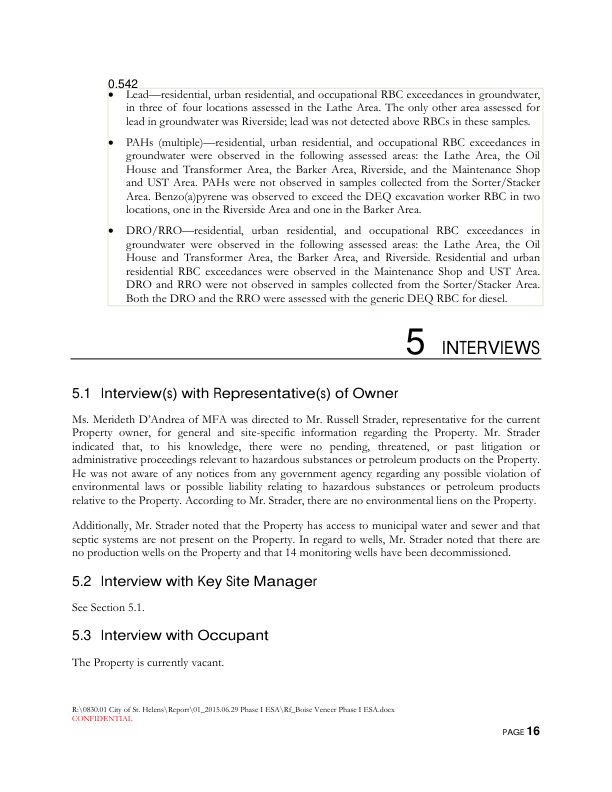

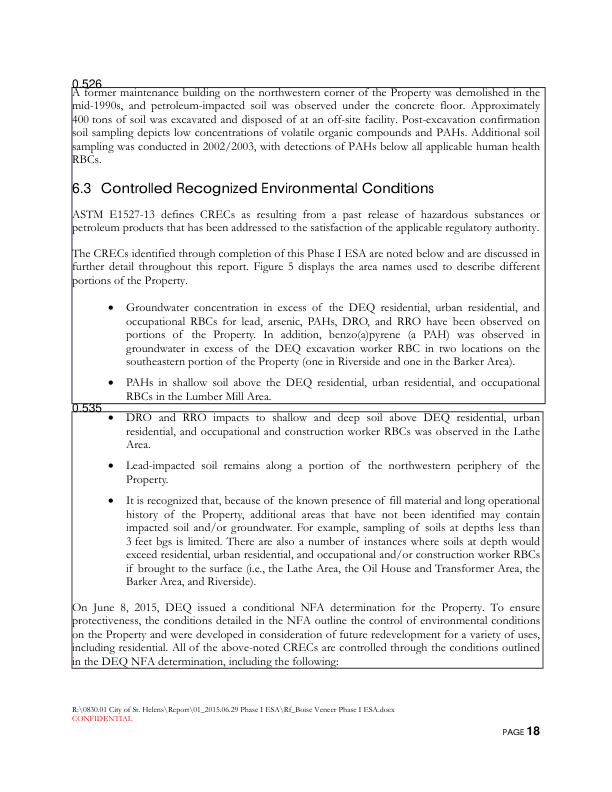

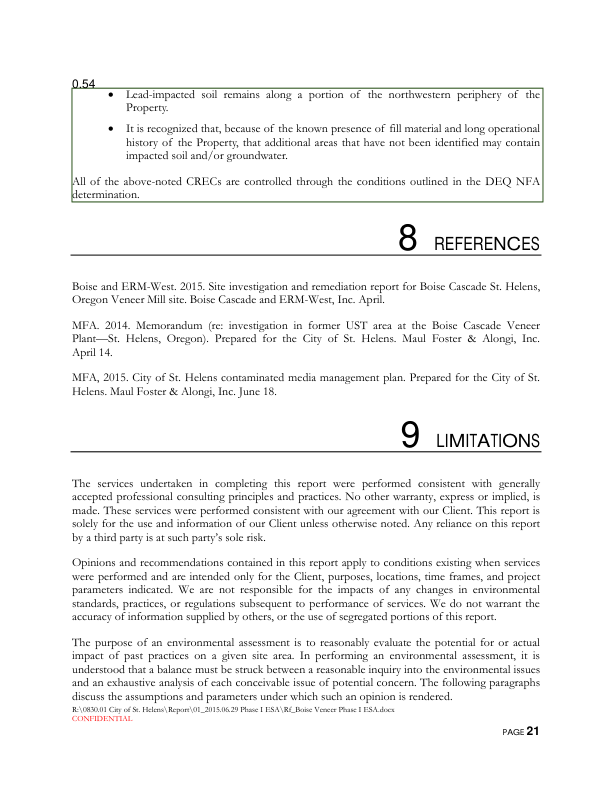

In [22]:
display_similar_nodes(similar_nodes, query_vector, pdf)

## 5: Structured Output

In [23]:
from pydantic import BaseModel


class ContainsHazards(BaseModel):
    has_lead: bool


response = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ],
    response_format=ContainsHazards,
)

response = response.choices[0].message.parsed
print(response)

has_lead=True


### Conditional Prompting

We can use the output of the model to drill into a more specific question. So in our case we found there was lead contamination, so we can ask a more specific question about the mitigations performed.

<img src="https://sergey-filimonov.nyc3.cdn.digitaloceanspaces.com/misc/misc-data-or-images-for-notebooks/structured-outputs-overview-v2.png" alt="Structured Outputs Overview">

In [24]:
if response.has_lead:
    question = "What mitigations have been performed up to this point to deal with the lead exposure?"

    query_vector = get_embedding(question)

    similar_nodes = db.find_similar_node(query_vector, top_k=5)

    context = "\n\n".join([node.text for node in similar_nodes])

    prompt = prompt_template.format(question=question, context=context)

    mitigations_performed = get_completion(prompt)

Completion used 1937 tokens costing $0.01


In [25]:
mitigations_performed

To mitigate lead exposure, the following actions have been taken:

1. **Excavation and Disposal**: Approximately 1,708 tons of lead-impacted soil were excavated from the northwestern periphery of the property and disposed of off-site. The cleanup targeted soil with lead concentrations above 400 parts per million (ppm) for soil up to 3 feet below ground surface (bgs) and 800 ppm for deeper soil.

2. **Conditional No Further Action (NFA) Determination**: The Department of Environmental Quality (DEQ) issued a conditional NFA determination for the property on June 8, 2015. This included conditions to control environmental conditions and manage any controlled recognized environmental conditions (CRECs) associated with the site, which acknowledge areas where residual contamination remains.

3. **Identification of CRECs**: Lead-impacted soil remaining along the property’s northwestern periphery is designated as a controlled recognized environmental condition (CREC). This includes safe-handling procedures stipulated in the Construction Management and Mitigation Plan (CMMP) for any future redevelopment, emphasizing that this area is a restricted zone.

4. **Site Security**: The property remains vacant and fenced, reducing the potential for unauthorized access and exposure to lead-impacted soil, particularly in the area identified as a CREC.

These activities collectively aim to manage, mitigate, and limit exposure to existing lead contamination on the property while preparing for potential future use under DEQ oversight and regulation.

In [26]:
question = (
    "Why were the following mitigations to remove the lead from the property ineffective "
    + mitigations_performed.data
)

query_vector = get_embedding(question)

# this is a more complex question, let's expand the search to top 9 nodes
similar_nodes = db.find_similar_node(query_vector, top_k=9)

context = "\n\n".join([node.text for node in similar_nodes])

prompt = prompt_template.format(question=question, context=context)

failure_reasons = get_completion(prompt)

Completion used 3326 tokens costing $0.01


In [27]:
failure_reasons

The mitigations to remove lead from the property were ineffective due to several key reasons:

1. **Residual Contamination**: Although approximately 1,708 tons of lead-impacted soil were removed, some residual lead contamination remained. In particular, a thin layer of residual soil on bedrock in the deepest parts of the excavation still had lead concentrations above the target cleanup levels. Additionally, residual lead levels above the risk-based concentrations (RBCs) for residential and construction/excavation workers were found along the northern sidewall of the excavation close to the property boundary. This indicates that the excavation did not fully eliminate the contamination.

2. **Physical Limitations**: Impacted soil near the property boundary could not be removed due to concerns about the structural integrity of an adjacent building to the north and the fact that neighboring properties were at a higher elevation. These physical constraints resulted in some contaminated soil remaining in place.

3. **Controlled Recognized Environmental Conditions (CRECs)**: The presence of CRECs indicates acknowledged areas where contamination remains, with associated conditions for management during future redevelopment. These CRECs, including the lead-impacted soil along the northwestern periphery, hinder complete cleanup efforts.

4. **Historical and Operational Factors**: The property's long history of operations and presence of fill material suggest that there may be additional unidentified areas with impacted soil or groundwater. Limited sampling of soils at depths less than 3 feet also indicates the potential for undiscovered contamination that was not addressed in the initial mitigation efforts.

5. **Groundwater and Soil Concerns**: Beyond just the soil, groundwater concentrations exceeded DEQ's RBCs for various contaminants, pointing to broader environmental issues that were not fully addressed by the soil excavation alone.

Overall, the combination of residual contamination, physical limitations on soil removal, CRECs, and unaddressed areas all contributed to the ineffectiveness of the lead mitigation efforts on the property.

## 6. Limitations to RAG

There's many classes of queries that can be challenging to answer with the architecture we've outlined thus far. 

1.	Temporal Reasoning: Answering time-specific questions, such as "what happened last quarter?" can be challenging because embeddings are designed to represent the general meaning of a phrase. They don’t inherently account for when events occurred. Without explicit mechanisms to distinguish between recent and older data, our RAG system cannot reliably retrieve time-sensitive responses.

2.	Conditional Reasoning: Queries with "if-then" logic present additional complexity. For instance, "If claim volume rose, what actions were taken?" requires the system to evaluate an initial condition (changes in claim volume) before retrieving data related to that condition. 

3.	Compound Queries: Actuarial analysis often requires decomposing complex questions into manageable parts, such as “Identify high-risk claims and summarize major patterns”, Since terms like “high-risk” may not explicitly appear in the data, this type of query requires a preprocessing step to define what constitutes a high-risk claim, such as specific claim attributes or risk factors.

Increasing the context windows of LLMs can brute force some of these limitations, but it also means that we can't use the same approach for longer documents.



### Advanced Challenges (Optional)

#### 1. Let's pass the entire document to ChatGPT and see if we get a different answer

In our example our document is short enough that we can pass the entire document to ChatGPT. This is very powerful, but it also means that we can't use the same approach for longer documents.

Once again if you're having trouble, you can find the full solution in the `./solutions.ipynb` notebook.

In [28]:
# Try combining all the nodes into one string,
# Hint: You can iterate across the original document nodes by using `for node in parsed_doc.nodes:`. Each Node has a `node.text` attribute!

# Create a prompt the same way we created one earlier except now pass the full document string

# Request a completion